In [1]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy



In [2]:
curr_dir = os.getcwd()


(128, 64, 3)


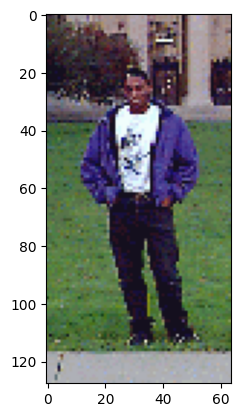

In [3]:
img = cv2.imread(f"{curr_dir}/pedestrians/pos/per00060.ppm")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.imshow(img)

In [4]:
def calc_gradient(img):
    dx = scipy . ndimage.convolve1d ( np . int32 ( img ) , np . array ([ -1 , 0, 1]) ,1)
    dy = scipy . ndimage.convolve1d ( np . int32 ( img ) , np . array ([ -1 , 0, 1]) ,0)
    grad = np.sqrt(dx ** 2 + dy ** 2)
    grad = grad / np.amax(grad)
    orient = np.arctan2(dy, dx)
    return grad, orient


def calc_rgb_gradients(img):
    grad_r, orientation_r = calc_gradient(img[:,:,0])
    grad_g, orientation_g = calc_gradient(img[:,:,1])
    grad_b, orientation_b = calc_gradient(img[:,:,2])

    grad = grad_b.copy()             # poczatkowo wynikowa macierz to gradient skladowej B
    m1 = grad_b - grad_g              # m1 - tablica pomocnicza do wyznaczania maksimum miedzy skladowymi B i G
    grad[m1 < 0] = grad_g[m1 < 0]    # w macierzy wynikowej gradienty skladowej B sa podmieniane na wieksze od nich gradienty skladowej G

    m2 = grad - grad_r
    grad[m2 < 0] = grad_r[m2 < 0]

    # oritnacje dla któych wartość gradientu była największa
    orient = orientation_b.copy()
    orient[m1 < 0] = orientation_g[m1 < 0]
    orient[m2 < 0] = orientation_r[m2 < 0]
    return grad, orient


In [5]:
import math


def calc_hist(img, size:int = 8):
    grad, orient = calc_rgb_gradients(img)
    orient = np.rad2deg(orient)
    YY_cell = np.int32(grad.shape[0] / size)
    XX_cell = np.int32(grad.shape[1] / size)
    hist = np.zeros((YY_cell, XX_cell, 9), dtype=np.float32)

    for y in range(YY_cell):
        for x in range(XX_cell):
            G = grad[y*size:(y+1)*size, x*size:(x+1)*size].flatten()
            O  = orient[y*size:(y+1)*size, x*size:(x+1)*size].flatten()
            for i in range(size**2):
                g = G[i]
                o = O[i]

                if o < 0:
                    o += 180

                o_mid = np.floor((o - 10) / 20) * 20 + 10
                if o_mid < 0:
                    o_mid = 170

                i0 = np.int32((o_mid - 10) / 20)
                i1 = i0 + 1
                if i1 == 9:
                    i1 = 0
                d = min(np.abs(o - o_mid), 180 - np.abs(o - o_mid)) / 20

                hist[y, x, i0] += g * (1 - d)
                hist[y, x, i1] += g * d
    return hist, YY_cell, XX_cell

def normalize_in_block(hist, YY_cell, XX_cell):
    e = math . pow (0.00001 ,2)
    F = []
    for jj in range (0 , YY_cell -1) :
        for ii in range (0 , XX_cell -1) :
            H0 = hist [jj ,ii ,:]
            H1 = hist [jj , ii +1 ,:]
            H2 = hist [ jj +1 , ii ,:]
            H3 = hist [ jj +1 , ii +1 ,:]
            H = np . concatenate (( H0 , H1 , H2 , H3 ))
            n = np . linalg . norm (H)
            Hn = H/ np . sqrt ( math . pow (n ,2) + e)
            F = np . concatenate ((F , Hn ))

    return F

In [6]:
hist, YY_cell, XX_cell = calc_hist(img)
F = normalize_in_block(hist, YY_cell, XX_cell)
print(F[:10])
print(len(F))



[0.32628486 0.14102182 0.10160698 0.12831481 0.14753036 0.09760303
 0.09749845 0.19737592 0.22033072 0.16186012]
3780


In [7]:
def HOGpicture(w, bs): # w - histogramy gradientow obrazu, bs - rozmiar komorki (u nas 8)
    bim1 = np.zeros((bs, bs))
    bim1[np.round(bs//2):np.round(bs//2)+1,:] = 1
    bim = np.zeros(bim1.shape+(9,))
    bim[:, :, 0] = bim1
    for i in range(0, 9): #2:9,
        bim[:, :, i] = scipy.ndimage.rotate(bim1, -i*20, mode='nearest', reshape=False)/255
        Y, X, Z = w.shape
        w[w < 0] = 0
        im = np.zeros((bs*Y, bs*X))
    for i in range(Y):
        iisl = (i)*bs
        iisu = (i+1)*bs
        for j in range(X):
            jjsl = j*bs
            jjsu=(j+1)*bs
            for k in range(9):
                im[iisl:iisu, jjsl:jjsu] += bim[:, :, k] * w[i, j, k]
    return im


def hog(img):
    hist, YY_cell, XX_cell = calc_hist(img)
    F = normalize_in_block(hist, YY_cell, XX_cell)
    return F

In [8]:
HOG_data = np.zeros([2*100, 3781], np.float32)

for i in range(0, 100):
    IP = cv2.imread('pedestrians/pos/per%05d.ppm' % (i+1))
    IN = cv2.imread('pedestrians/neg/neg%05d.png' % (i+1))
    F = hog(IP)
    HOG_data[i, 0] = 1
    HOG_data[i, 1:] = F
    F = hog(IN)
    HOG_data[i+100, 0] = 0
    HOG_data[i+100, 1:] = F

labels = HOG_data[:, 0]
data = HOG_data[:, 1:]


In [9]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.2, random_state=42)

clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(data_train, labels_train)


SVC(kernel='linear')

In [10]:
lp = clf.predict(data_train)

print(data_train[0].shape)
tn, fp, fn, tp = confusion_matrix(labels_train, lp).ravel()
print("tn: ", tn)
print("fp: ", fp)
print("fn: ", fn)
print("tp: ", tp)

(3780,)
tn:  81
fp:  0
fn:  0
tp:  79


In [11]:
lp = clf.predict(data_test)

tn, fp, fn, tp = confusion_matrix(labels_test, lp).ravel()
print("tn: ", tn)
print("fp: ", fp)
print("fn: ", fn)
print("tp: ", tp)


tn:  19
fp:  0
fn:  0
tp:  21


In [12]:
accuracy = accuracy_score(labels_test, lp)
print('Accuracy:', accuracy)

Accuracy: 1.0


In [13]:
from sklearn.metrics import pairwise

def non_max_suppression(boxes, overlapThresh):
    if len(boxes) == 0:
        return []

    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:last]]

        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

(498, 703, 3)


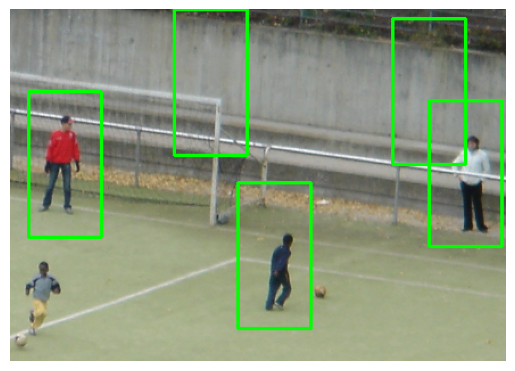

In [14]:
# zadanie 3

img = cv2.imread(f"{curr_dir}/pedestrians_testowy/testImage1.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
img_resized = cv2.resize(img, None, fx=0.62, fy=0.62)
img_copy = img_resized.copy()
boxes = []
for x in range(0, int(img_resized.shape[1] - 64), 8):
    for y in range(0, int(img_resized.shape[0] - 128), 8):  
        window = img_resized[y:y+128, x:x+64]
        F = hog(window)
        lp = clf.predict([F])
        if lp == 1:
            boxes.append([x, y, x+64, y+128])

boxes = np.array(boxes)
# Apply non-maximum suppression
boxes = non_max_suppression(boxes, 0.3)

# Draw the final boxes on the image
for (x1, y1, x2, y2) in boxes:
    cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure()
plt.imshow(img_copy)
plt.axis('off')
plt.show()

(640, 480, 3)


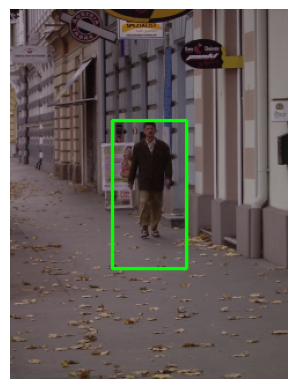

In [15]:
# zadanie 3

img = cv2.imread(f"{curr_dir}/pedestrians_testowy/testImage2.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
img_resized = cv2.resize(img, None, fx=0.5, fy=0.5)
img_copy = img_resized.copy()
boxes = []
for x in range(0, int(img_resized.shape[1] - 64), 8):
    for y in range(0, int(img_resized.shape[0] - 128), 8):  
        window = img_resized[y:y+128, x:x+64]
        F = hog(window)
        lp = clf.predict([F])
        if lp == 1:
            boxes.append([x, y, x+64, y+128])

boxes = np.array(boxes)
# Apply non-maximum suppression
boxes = non_max_suppression(boxes, 0.3)

# Draw the final boxes on the image
for (x1, y1, x2, y2) in boxes:
    cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure()
plt.imshow(img_copy)
plt.axis('off')
plt.show()

(151, 148, 3)


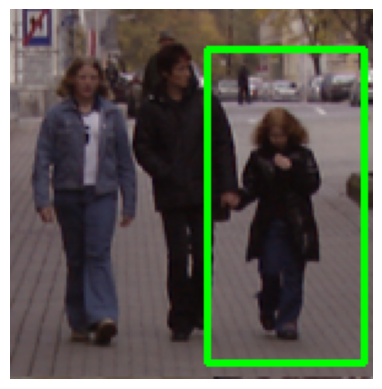

In [16]:
# zadanie 3

img = cv2.imread(f"{curr_dir}/pedestrians_testowy/testImage3.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
img_resized = cv2.resize(img, None, fx=1, fy=1)
img_copy = img_resized.copy()
boxes = []
for x in range(0, int(img_resized.shape[1] - 64), 8):
    for y in range(0, int(img_resized.shape[0] - 128), 8):  
        window = img_resized[y:y+128, x:x+64]
        F = hog(window)
        lp = clf.predict([F])
        if lp == 1:
            boxes.append([x, y, x+64, y+128])

boxes = np.array(boxes)
# Apply non-maximum suppression
boxes = non_max_suppression(boxes, 0.3)

# Draw the final boxes on the image
for (x1, y1, x2, y2) in boxes:
    cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure()
plt.imshow(img_copy)
plt.axis('off')
plt.show()

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


(363, 332, 3)


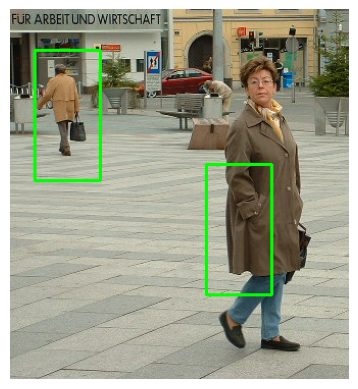

In [17]:
# zadanie 3

img = cv2.imread(f"{curr_dir}/pedestrians_testowy/testImage4.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
img_resized = cv2.resize(img, None, fx=1, fy=1)
img_copy = img_resized.copy()
boxes = []
for x in range(0, int(img_resized.shape[1] - 64), 8):
    for y in range(0, int(img_resized.shape[0] - 128), 8):  
        window = img_resized[y:y+128, x:x+64]
        F = hog(window)
        lp = clf.predict([F])
        if lp == 1:
            boxes.append([x, y, x+64, y+128])

boxes = np.array(boxes)
# Apply non-maximum suppression
boxes = non_max_suppression(boxes, 0.3)

# Draw the final boxes on the image
for (x1, y1, x2, y2) in boxes:
    cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure()
plt.imshow(img_copy)
plt.axis('off')
plt.show()